In [ ]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report


# Paths
DATA_PATH = "../data/processed/reviews_validation.csv"
MODEL_PATH = "../reports/svm_bigram_softneg_model.joblib"


# Load data
df = pd.read_csv(DATA_PATH)
df["review_text"] = df["review_text"].fillna("").astype(str)
df = df[df["review_text"].str.len() >= 30].copy()

X = df["review_text"]
y = df["recommended"].astype(int)


In [3]:
# Trained model
model = joblib.load(MODEL_PATH)
tfidf = model.named_steps["tfidf"]
clf = model.named_steps["clf"]
feature_names = tfidf.get_feature_names_out()
coefs = clf.coef_[0]

y_pred = model.predict(X)
scores = model.decision_function(X)

In [ ]:


# ROC-AUC
roc_auc = roc_auc_score(y, scores)

# Matrice de confusion
cm = confusion_matrix(y, y_pred)

print(f"ROC-AUC: {roc_auc:.4f}")
print("Confusion matrix:\n", cm)
print(classification_report(y, y_pred, digits=4))

ROC-AUC: 0.9098
Confusion matrix:
 [[ 779  295]
 [ 396 3682]]
              precision    recall  f1-score   support

           0     0.6630    0.7253    0.6928      1074
           1     0.9258    0.9029    0.9142      4078

    accuracy                         0.8659      5152
   macro avg     0.7944    0.8141    0.8035      5152
weighted avg     0.8710    0.8659    0.8680      5152



In [6]:
# Index TP / FP / TN / FN

idx_tp = np.where((y == 1) & (y_pred == 1))[0]
idx_fp = np.where((y == 0) & (y_pred == 1))[0]
idx_tn = np.where((y == 0) & (y_pred == 0))[0]
idx_fn = np.where((y == 1) & (y_pred == 0))[0]


In [7]:
# TF-IDF representation of test set (convert text to vectors)
X_test_tfidf = tfidf.transform(X)

In [8]:
# Inspect most discriminant features

feature_names = tfidf.get_feature_names_out()
coefs = clf.coef_[0]

top_pos = np.argsort(coefs)[-20:]
top_neg = np.argsort(coefs)[:20]

print("\nTop POSITIVE features:")
for i in top_pos[::-1]:
    print(feature_names[i], coefs[i])

print("\nTop NEGATIVE features:")
for i in top_neg:
    print(feature_names[i], coefs[i])



Top POSITIVE features:
best 2.4187384996737586
good 2.117917069737305
fun 2.080045345762152
great 1.9947010292632836
love 1.8790545805181915
peak 1.4418779922545757
amazing 1.436393512388377
bit 1.358890441861667
awesome 1.3310469574224901
perfect 1.3147514436471073
10 10 1.2491921698210853
enjoyable 1.2438597584789812
10 1.1273444410921805
masterpiece 1.127098487108646
great game 1.068425201269243
very fun 1.0638844578545505
now 1.046624273330734
funny 1.0184322139274948
but 1.0144592044380067
better than 1.0026506617454038

Top NEGATIVE features:
worst -2.0953963864307825
shit -1.931321910465415
even -1.7300796178932227
terrible -1.7289142685568384
boring -1.703230346576017
garbage -1.6643283985593174
payday -1.6345095279581914
the worst -1.6304016081300277
trash -1.6177786697773866
unplayable -1.596642248219046
refund -1.52616185247189
sucks -1.5207323455459258
crashing -1.4754472963524674
bf6 -1.4748556815477107
ea -1.4476349594823972
not -1.43875010173813
job -1.4237218707010988


In [9]:
# Discriminant contribution function

def discriminant_table(X_tfidf, indices, label, top_n=10):
    X_sub = X_tfidf[indices]
    contrib = X_sub.multiply(coefs).sum(axis=0).A1
    top_idx = np.argsort(np.abs(contrib))[::-1][:top_n]
    return pd.DataFrame({
        "word": feature_names[top_idx],
        f"contribution_{label}": contrib[top_idx]
    })

In [10]:
# Tables

tp = discriminant_table(X_test_tfidf, idx_tp, "TP")
fp = discriminant_table(X_test_tfidf, idx_fp, "FP")
tn = discriminant_table(X_test_tfidf, idx_tn, "TN")
fn = discriminant_table(X_test_tfidf, idx_fn, "FN")

In [11]:
# Comparisons

tp_fp = tp.merge(fp, on="word", how="outer").fillna(0)
tn_fn = tn.merge(fn, on="word", how="outer").fillna(0)

# Sort by correct decision contribution

tp_fp = tp_fp.sort_values("contribution_TP", ascending=False).reset_index(drop=True)
tn_fn = tn_fn.assign(abs_TN=lambda x: x.contribution_TN.abs()) \
               .sort_values("abs_TN", ascending=False) \
               .drop(columns="abs_TN") \
               .reset_index(drop=True)


print("\nTop TP vs FP words (sorted by TP):")
print(tp_fp.head(10))

print("\nTop TN vs FN words (sorted by |TN|):")
print(tn_fn.head(10))


Top TP vs FP words (sorted by TP):
    word  contribution_TP  contribution_FP
0    fun       154.404776         7.527376
1   good       137.069527         8.233004
2  great       131.445487         5.369340
3   best       116.520314         0.000000
4   love        96.371294         0.000000
5    but        67.448944         7.461588
6     10        59.217936         0.000000
7     is         0.000000        -4.719560
8   just         0.000000        -5.350004
9    the         0.000000        -4.745145

Top TN vs FN words (sorted by |TN|):
     word  contribution_TN  contribution_FN
0     not       -29.409931       -10.207881
1      to       -21.191822       -10.144783
2    just       -20.712003        -9.173404
3    they       -19.112192        -8.525325
4    this       -18.548064        -8.913288
5    even       -17.659972         0.000000
6      no       -17.263953        -5.668502
7  boring       -15.440079         0.000000
8     but        14.951737         6.950933
9     fun    

In [12]:
print("Faux positifs :")
print(fp.head(15))

print("Faux négatifs :")
print(fn.head(15))

Faux positifs :
    word  contribution_FP
0   good         8.233004
1    not        -7.734700
2    fun         7.527376
3    but         7.461588
4     to        -5.888747
5   this        -5.752200
6  great         5.369340
7   just        -5.350004
8    the        -4.745145
9     is        -4.719560
Faux négatifs :
   word  contribution_FN
0   not       -10.207881
1    to       -10.144783
2  just        -9.173404
3  this        -8.913288
4  they        -8.525325
5   but         6.950933
6   the        -5.905806
7    is        -5.799114
8    no        -5.668502
9   fun         5.531788


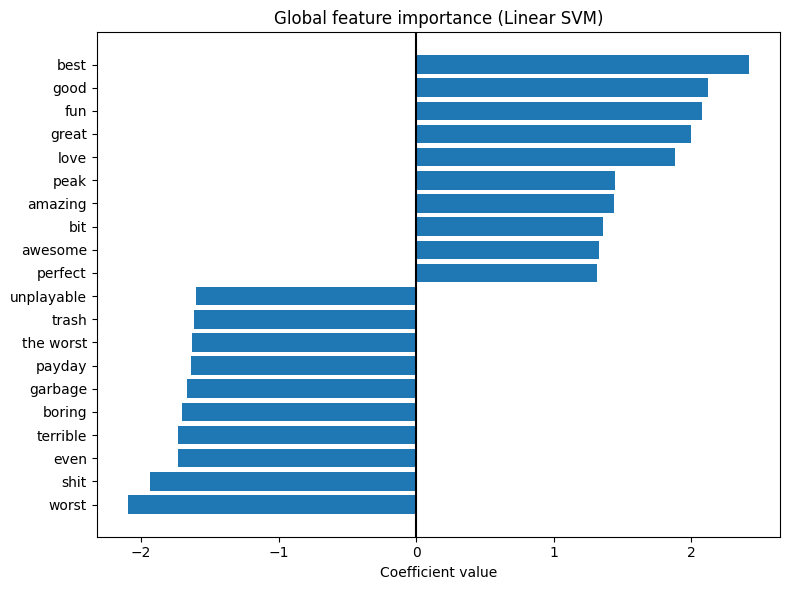

In [16]:
# Coefficients of the linear SVM
coef_df = pd.DataFrame({
    "word": feature_names,
    "coef": coefs
})

# Selection
top_pos = coef_df.sort_values("coef", ascending=False).head(10)
top_neg = coef_df.sort_values("coef", ascending=True).head(10)

top_pos = top_pos.sort_values("coef", ascending=True)

# Concatenation
top = pd.concat([top_neg, top_pos])

# Plot
plt.figure(figsize=(8, 6))
plt.barh(top["word"], top["coef"])
plt.axvline(0, color="black")
plt.title("Global feature importance (Linear SVM)")
plt.xlabel("Coefficient value")
plt.tight_layout()
plt.show()

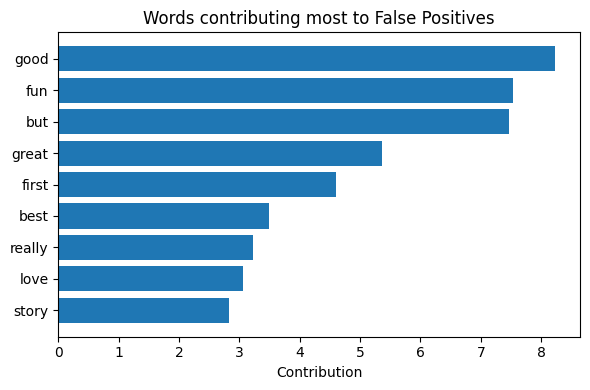

In [17]:
fp_words = discriminant_table(X_test_tfidf, idx_fp, "FP", top_n=20)
fp_words = fp_words[fp_words["contribution_FP"] > 0] \
                     .sort_values("contribution_FP", ascending=True) \
                     .head(10)

plt.figure(figsize=(6, 4))
plt.barh(fp_words["word"], fp_words["contribution_FP"])
plt.title("Words contributing most to False Positives")
plt.xlabel("Contribution")
plt.tight_layout()
plt.show()

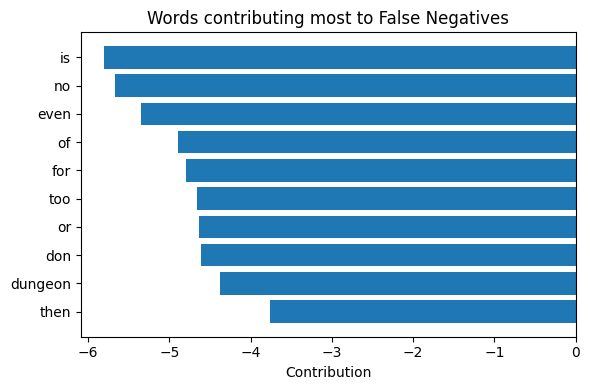

In [18]:
fn_words = discriminant_table(X_test_tfidf, idx_fn, "FN", top_n=20)
fn_words = fn_words[fn_words["contribution_FN"] < 0] \
                     .sort_values("contribution_FN", ascending = False) \
                     .head(10)

plt.figure(figsize=(6, 4))
plt.barh(fn_words["word"], fn_words["contribution_FN"])
plt.title("Words contributing most to False Negatives")
plt.xlabel("Contribution")
plt.tight_layout()
plt.show()


False negatives mostly correspond to linguistically nuanced positive reviews rather than lexically negative ones.